In [1]:
import dataclasses
from typing import Literal

import pandas as pd
from rdkit.Chem import MolFromSmiles, Mol, PandasTools, rdChemReactions, Draw, Mol
from rdkit.Chem.rdChemReactions import ReactionFromSmarts

PandasTools.RenderImagesInAllDataFrames()
PandasTools.molRepresentation = 'svg'
PandasTools.molSize = (600, 300)

In [2]:
@dataclasses.dataclass(frozen=True)
class MolData:
    smiles: str
    name: str
    abbr: str | None
    func: Literal['reactant', 'product']
    rc_atom_idxs: list[int]

In [3]:
mols = {
    'coa': MolData(
        smiles='CC(C)(COP(=O)(O)OP(=O)(O)OCC1OC(n2cnc3c(N)ncnc32)C(O)C1OP(=O)(O)O)C(O)C(=O)NCCC(=O)NCCS',
        name='Coenzyme A',
        abbr='CoA',
        func='reactant',
        rc_atom_idxs=[47],
    ),
    'epa': MolData(
        smiles='CCCCCC=CCC=CCC=CC=CC(O)CCCC(=O)O',
        name='Eicosapentaenoic acid',
        abbr='EPA',
        func='reactant',
        rc_atom_idxs=[20, 22],
    ),
    'gtp': MolData(
        smiles='Nc1ncnc2c1ncn2C1OC(COP(=O)(O)OP(=O)(O)OP(=O)(O)O)C(O)C1O',
        name='Guanosine triphosphate',
        abbr='GTP',
        func='reactant',
        rc_atom_idxs=[18, 15],
    ),
    'epa_coa': MolData(
        smiles='CCCCCC=CCC=CCC=CC=CC(O)CCCC(=O)SCCNC(=O)CCNC(=O)C(O)C(C)(C)COP(=O)(O)OP(=O)(O)OCC1OC(n2cnc3c(N)ncnc32)C(O)C1OP(=O)(O)O',
        name='Eicosapentaenoyl-CoA',
        abbr='EPA-CoA',
        func='product',
        rc_atom_idxs=[20, 22],
    ),
    'diphos': MolData(
        smiles='O=P(O)(O)OP(=O)(O)O',
        name='Diphosphate (Pyrophosphate)',
        abbr=None,
        func='product',
        rc_atom_idxs=[2],
    ),
    'gmp': MolData(
        smiles='Nc1ncnc2c1ncn2C1OC(COP(=O)(O)O)C(O)C1O',
        name='Guanosine monophosphate',
        abbr='GMP',
        func='product',
        rc_atom_idxs=[17, 15],
    ),
}

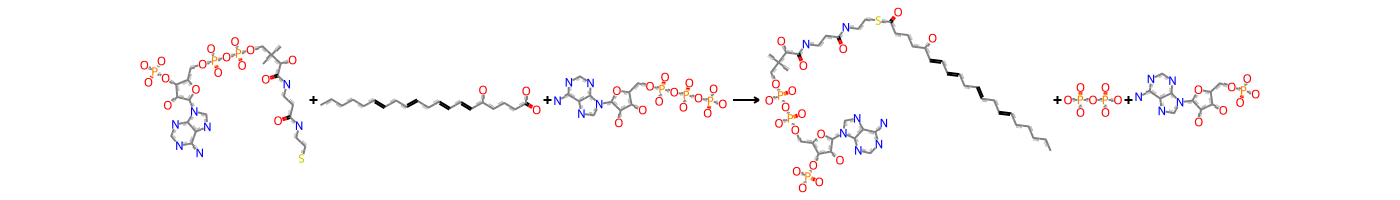

In [4]:
# Construct the Reaction SMARTS string
rxn_smarts = "{coa}.{epa}.{gtp}>>{epa_coa}.{diphos}.{gmp}".format(**{k: mol.smiles for k, mol in mols.items()})
rxn = rdChemReactions.ReactionFromSmarts(rxn_smarts)

# Save SVG and display the reaction image
img_size = (500, 500)

with open("/Users/pasha/rxn.svg", "w") as svg_file:
    svg = Draw.ReactionToImage(rxn, useSVG=True)
    svg_file.write(svg)
    
Draw.ReactionToImage(rxn)

In [5]:
df = pd.DataFrame.from_records(map(dataclasses.asdict, mols.values()))
PandasTools.AddMoleculeColumnToFrame(df, smilesCol='smiles', molCol='mol', includeFingerprints=True)

def highlight_rcs(df: pd.DataFrame) -> pd.DataFrame:
    for i, mol_data in enumerate(mols.values()):
        mol = df.loc[i].mol
        mol.__sssAtoms = mol_data.rc_atom_idxs 
        for a_idx in mol_data.rc_atom_idxs:
            atom = mol.GetAtomWithIdx(a_idx)
            atom.SetProp("atomNote", "RC")
    return df

df = highlight_rcs(df)
df_reac = df.loc[df.func == 'reactant']
df_prod = df.loc[df.func == 'product']
df

smiles  \
0  CC(C)(COP(=O)(O)OP(=O)(O)OCC1OC(n2cnc3c(N)ncnc...   
1                   CCCCCC=CCC=CCC=CC=CC(O)CCCC(=O)O   
2  Nc1ncnc2c1ncn2C1OC(COP(=O)(O)OP(=O)(O)OP(=O)(O...   
3  CCCCCC=CCC=CCC=CC=CC(O)CCCC(=O)SCCNC(=O)CCNC(=...   
4                                O=P(O)(O)OP(=O)(O)O   
5             Nc1ncnc2c1ncn2C1OC(COP(=O)(O)O)C(O)C1O   

                          name     abbr      func rc_atom_idxs  \
0                   Coenzyme A      CoA  reactant         [47]   
1        Eicosapentaenoic acid      EPA  reactant     [20, 22]   
2       Guanosine triphosphate      GTP  reactant     [18, 15]   
3         Eicosapentaenoyl-CoA  EPA-CoA   product     [20, 22]   
4  Diphosphate (Pyrophosphate)     None   product          [2]   
5      Guanosine monophosphate      GMP   product     [17, 15]   

                                             mol  
0  <rdkit.Chem.rdchem.Mol object at 0x15f771070>  
1  <rdkit.Chem.rdchem.Mol object at 0x15f771230>  
2  <rdkit.Chem.rdchem.Mol object at 0x15f771310>  
3  <rdkit.Chem.rdchem.Mol object at 0x15f7713f0>  
4  <rdkit.Chem.rdchem.Mol object at 0x15f7714d0>  
5  <rdkit.Chem.rdchem.Mol object at 0x15f7715b0>

In [6]:
with open('/Users/pasha/fig.html', 'w') as f:
    f.write(df.to_html())

In [7]:
import dataframe_image as dfi

In [8]:
dfi.export(df_reac, '/Users/pasha/rxn_tbl_reac.png', table_conversion='html2image', max_rows=-1, max_cols=-1, dpi=1000)
dfi.export(df_prod, '/Users/pasha/rxn_tbl_prod.png', table_conversion='html2image', max_rows=-1, max_cols=-1, dpi=1000)

1790641 bytes written to file /Users/pasha/.cache/html2image/screenshot.png
1765124 bytes written to file /Users/pasha/.cache/html2image/screenshot.png
